<a href="https://colab.research.google.com/github/caiocfpeixoto/VGG16_RANDOM_FOREST/blob/main/VGG16_%26_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import de pacotes necessários

In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import os
from PIL import Image

import matplotlib.pyplot as plt
import glob

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPooling2D

from keras.applications import VGG16

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from keras.utils import  to_categorical
from sklearn import metrics
from sklearn.metrics import confusion_matrix

Conexão com Google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset dividido em ***Train***, ***Test*** e ***val***. Cada um diretórios é dividido em duas categorias:


*   POSITIVA
*   NEGATIVA

A função abaixo percorre o diretório e cria labels para as imagens:

In [3]:
SIZE = 120
def datafunc(datadir):
    images = []
    labels = []
    for dir_path in glob.glob(datadir):
        label = dir_path.split('/')[-1]
        print(label)
        for img_path in glob.glob(os.path.join(dir_path, '*.tif')):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (SIZE, SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(e)

    return np.array(images), np.array(labels)

Interando cada diretório e criando as respectivas labels

In [4]:
train_images, train_labels = datafunc('/content/drive/MyDrive/Celulas Cervicais/train/*')
test_images, test_labels = datafunc('/content/drive/MyDrive/Celulas Cervicais/test/*')
val_images, val_labels = datafunc('/content/drive/MyDrive/Celulas Cervicais/val/*')

NEGATIVA
POSITIVA
NEGATIVA
POSITIVA
POSITIVA
NEGATIVA


Demonstrar os dados em gráficos

Text(0.5, 1.0, 'Validation data')

<Figure size 2000x500 with 0 Axes>

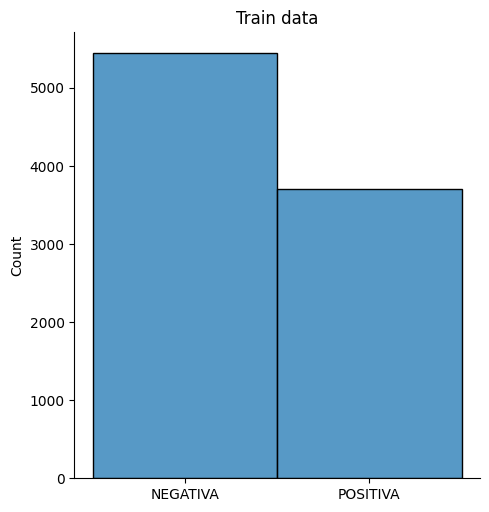

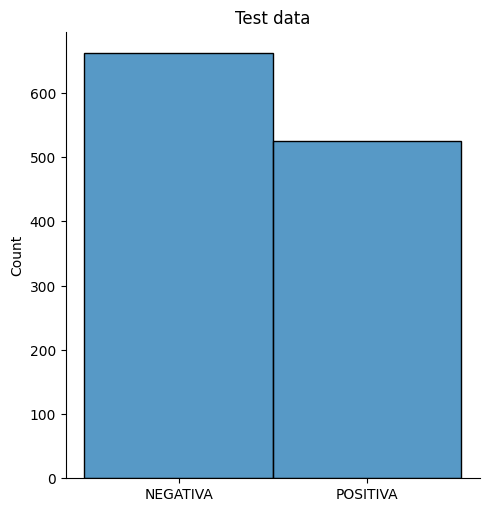

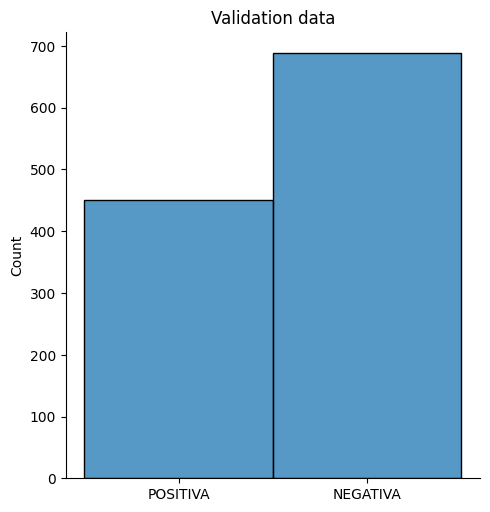

In [5]:
plt.figure(figsize=(20,5))

# plt.subplot(1,3,1)
sns.displot(train_labels)
plt.title('Train data')

# plt.subplot(1,3,2)
sns.displot(test_labels)
plt.title('Test data')

# plt.subplot(1,3,3)
sns.displot(val_labels)
plt.title('Validation data')

# plt.show()

Verificando a quantidade de ocorrências das labels, será necessário fazer um downshape dos dados pois a quantidade está desbalanceada

In [10]:
df = pd.DataFrame({'label': train_labels, 'images': list(train_images)}, columns=['label', 'images'])

count_class_0, count_class_1 = df.label.value_counts()

df_class_0 = df[df['label'] == 'NEGATIVA']
df_class_1 = df[df['label'] == 'POSITIVA']

print('NEGATIVA =', count_class_0)
print('POSITIVA =', count_class_1)

NEGATIVA = 5440
POSITIVA = 3704


Dados balanceados

Random under-sampling:
NEGATIVA    3704
POSITIVA    3704
Name: label, dtype: int64


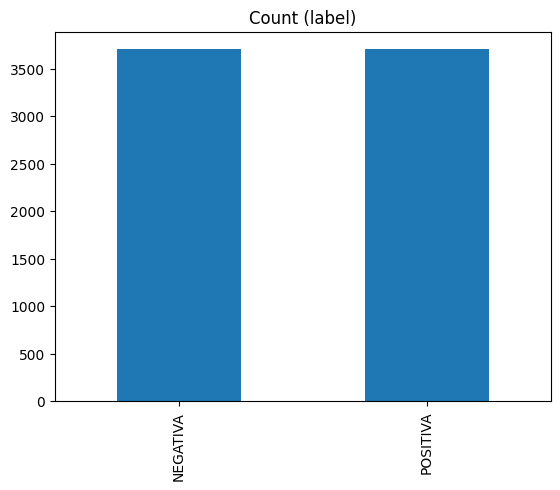

In [11]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.label.value_counts().plot(kind='bar', title='Count (label)');

Convertendo Dataframe para array

In [12]:
t_images = []
for img in df_test_under['images']:
    img = Image.fromarray(img)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    t_images.append(img)
t_images = np.array(t_images)
train_labels = np.array(df_test_under['label'])

In [13]:
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = t_images, train_labels_encoded, test_images, test_labels_encoded
x_train, x_test = x_train / 255.0, x_test / 255.0 #scaling the data

In [14]:
VGG_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (SIZE, SIZE, 3))

for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                              

In [15]:
feature_extractor = VGG_model.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_rf = features

232/232 [==============================] - 1370s 6s/step


In [16]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)

RF_model.fit(X_rf, y_train)

X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

prediction_RF = RF_model.predict(X_test_features)

38/38 [==============================] - 221s 6s/step


Accuracy = 0.7531592249368155
Recall = 0.8435754189944135
Precision = 0.6842900302114804


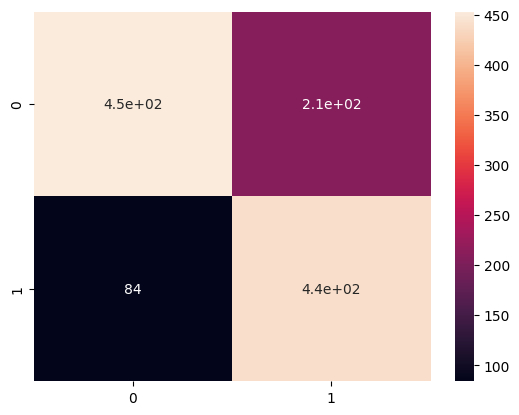

In [17]:
cm = confusion_matrix(y_test, prediction_RF)
sns.heatmap(cm, annot = True)

tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_test, prediction_RF))
print("Recall =", recall)
print("Precision =", precision)